In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pickle
import math
from bidict import bidict
from tqdm import tqdm
from utils.dataset import generate_dataset
from utils.Profiler import Profiler
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
from SequentialGroup import Column, Group, Node, Link

np.random.seed(0)
torch.manual_seed(0)



In [2]:
def plot_curve(y, color='#1F77B4', color2="#82B0D2", window_size = 1000, y_bottom=None, y_top=None, label=None):
    s = pd.Series(y)
    s_ma = s.rolling(window=window_size, min_periods=1).mean()
    upper_quartile = s.rolling(window=window_size, min_periods=1).quantile(0.75)
    lower_quartile = s.rolling(window=window_size, min_periods=1).quantile(0.25)
    # plt.plot(s, c=color2, alpha=0.3, zorder=2)
    plt.fill_between(s.index, lower_quartile, upper_quartile, color=color2, zorder=4)
    plt.plot(s_ma, color=color, label=label, zorder=6)
    plt.ylim(bottom=y_bottom, top=y_top)

In [3]:
seq1 = ['A', 'B', 'C', 'D', 'E']
seq2 = ['X', 'B', 'C', 'D', 'Y']
seqs = [seq1, seq2]

D_train, _, dictionary = generate_dataset(seqs)
data = D_train[:5000]

In [4]:
data_ = torch.tensor(data)


In [5]:
embeddings = np.random.uniform(-1, 1, size=(27, 32))
mapping = dict({i: embeddings[i] for i in range(len(embeddings))})

## LSTM

In [6]:
class SeL_LSTM(nn.Module):
    def __init__(self, embeddings: torch.Tensor, num_layers, hidden_size, seq_length, dropout=0.1):
        super(SeL_LSTM, self).__init__()
        self.seq_length = seq_length
        
        embed = torch.FloatTensor(embeddings)
        self.embedding = nn.Embedding(num_embeddings=embed.shape[0], embedding_dim=embed.shape[1], _weight=embed)
        
        self.lstm = nn.LSTM(input_size=embed.shape[1], hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.Linear(hidden_size, embed.shape[0])

    def forward(self, src):
        src = self.embedding(src)
        lstm_out, _ = self.lstm(src)
        output = self.decoder(lstm_out[:, -1, :])
        return output

In [7]:
num_layers = 2
num_heads = 4
seq_length = 4
dropout = 0.1

# Initialize model, loss function, and optimizer
model = SeL_LSTM(embeddings, num_layers, num_heads, seq_length, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
losses = []
accuracies1 = []
profiler = Profiler(100)
n_span = seq_length
topk = 1
for i in tqdm(range(n_span, len(data_))):
    src, tgt = data_[i-n_span:i], data_[i:i+1]

    optimizer.zero_grad()
    pred: torch.Tensor = model(src.unsqueeze(0))
    loss = criterion(pred.view(-1, pred.shape[-1]), tgt.view(-1))
    # loss = criterion(output, tgt.unsqueeze(0))
    loss.backward()
    optimizer.step()


    losses.append(float(loss))
    if i%100 == 0:
        print(losses[-1])

    # labels = torch.argmax(pred.detach(), dim=-1)
    _, labels = torch.topk(pred.detach(), topk)
    anticipations = set(labels.squeeze(0).tolist())
    acc = profiler.observe(anticipations, int(tgt))
    
    accuracies1.append(float(acc))


  6%|▌         | 281/4996 [00:00<00:04, 955.47it/s]

3.1190199851989746
3.341696262359619
2.999910831451416


 12%|█▏        | 617/4996 [00:00<00:04, 1078.02it/s]

3.214792013168335
2.4286561012268066
3.273164749145508


 17%|█▋        | 838/4996 [00:00<00:03, 1074.98it/s]

2.6150550842285156
3.0552492141723633
2.543056011199951


 23%|██▎       | 1154/4996 [00:01<00:03, 1018.88it/s]

3.0703999996185303
2.5271387100219727
2.8212177753448486


 29%|██▉       | 1458/4996 [00:01<00:03, 934.10it/s] 

2.254535436630249
2.893503189086914


 33%|███▎      | 1661/4996 [00:01<00:03, 969.66it/s]

2.5328187942504883
2.560659885406494
2.2366414070129395


 40%|███▉      | 1975/4996 [00:01<00:02, 1018.63it/s]

2.4862120151519775
2.1990742683410645
2.486154317855835


 46%|████▌     | 2303/4996 [00:02<00:02, 1066.54it/s]

2.200063705444336
2.4062721729278564
2.0461935997009277


 51%|█████     | 2523/4996 [00:02<00:02, 1079.52it/s]

2.619107246398926
2.031132221221924
2.1533584594726562


 57%|█████▋    | 2861/4996 [00:02<00:01, 1109.27it/s]

1.9692069292068481
2.6818671226501465
1.7724192142486572


 64%|██████▍   | 3202/4996 [00:03<00:01, 1125.56it/s]

2.3915317058563232
1.6749298572540283
2.331885814666748


 69%|██████▊   | 3429/4996 [00:03<00:01, 1129.90it/s]

1.6520954370498657
1.9644815921783447
1.5084941387176514


 76%|███████▌  | 3772/4996 [00:03<00:01, 1129.68it/s]

1.9149949550628662
1.4567431211471558
1.8789716958999634


 82%|████████▏ | 4117/4996 [00:03<00:00, 1138.40it/s]

1.4228394031524658
1.8180888891220093
1.3752927780151367


 87%|████████▋ | 4345/4996 [00:04<00:00, 1128.91it/s]

1.728172779083252
1.3883848190307617
1.6054695844650269


 94%|█████████▍| 4689/4996 [00:04<00:00, 1139.54it/s]

1.2565319538116455
1.6542850732803345
1.1492356061935425


100%|██████████| 4996/4996 [00:04<00:00, 1073.30it/s]

1.8402352333068848
1.1433801651000977


Text(0.5, 0, 'event')

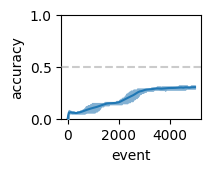

In [9]:
plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve(accuracies1[:50000], y_bottom=0, y_top=1, label="all")
plt.axhline(0.5, color='#999999', alpha=0.5, linestyle='--', zorder=5)
# plot_curve(accuracies1_2[:50000], color="#2CA02C", color2="#8ECFC9", y_bottom=0, y_top=1, label="Top1")
# plt.legend(loc='upper right')
plt.ylabel("accuracy")
plt.xlabel("event")

## Transformer

In [10]:

class SeL_Transformer(nn.Module):
    def __init__(self, embeddings: torch.Tensor, num_layers, num_heads, seq_length, dropout=0.1):
        super(SeL_Transformer, self).__init__()
        self.seq_length = seq_length
        
        hidden_size = embeddings.shape[1]
        
        embed = torch.FloatTensor(embeddings)
        self.embedding = nn.Embedding(num_embeddings=embed.shape[0], embedding_dim=embed.shape[1], _weight=embed)
        
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, hidden_size))
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_size, embed.shape[0])

    def forward(self, src):
        src = self.embedding(src) + self.positional_encoding[:, :self.seq_length, :]
        output = self.transformer_encoder(src)
        output = self.decoder(output[:, -1, :])
        return output

In [11]:
num_layers = 2
num_heads = 4
seq_length = len(seq1)
dropout = 0.1

# Initialize model, loss function, and optimizer
model = SeL_Transformer(embeddings, num_layers, num_heads, seq_length, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

/opt/homebrew/Caskroom/miniforge/base/envs/PyNARS/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [12]:
losses = []
accuracies2 = []
profiler = Profiler(100)
n_span = seq_length
topk = 1
for i in tqdm(range(n_span, len(data_))):
    src, tgt = data_[i-n_span:i], data_[i:i+1]

    optimizer.zero_grad()
    pred: torch.Tensor = model(src.unsqueeze(0))
    loss = criterion(pred.view(-1, pred.shape[-1]), tgt.view(-1))
    # loss = criterion(output, tgt.unsqueeze(0))
    loss.backward()
    optimizer.step()


    losses.append(float(loss))
    if i%100 == 0:
        print(losses[-1])

    # labels = torch.argmax(pred.detach(), dim=-1)
    _, labels = torch.topk(pred.detach(), topk)
    anticipations = set(labels.squeeze(0).tolist())
    acc = profiler.observe(anticipations, int(tgt))
    
    accuracies2.append(float(acc))


  3%|▎         | 129/4995 [00:00<00:30, 159.14it/s]

1.8090460300445557


  4%|▍         | 219/4995 [00:01<00:27, 171.87it/s]

4.978393077850342


  7%|▋         | 330/4995 [00:02<00:27, 172.18it/s]

0.6236518621444702


  8%|▊         | 418/4995 [00:02<00:27, 166.03it/s]

1.7606031894683838


 10%|█         | 521/4995 [00:03<00:27, 159.99it/s]

2.050177574157715


 13%|█▎        | 629/4995 [00:03<00:25, 171.76it/s]

1.5179897546768188


 14%|█▍        | 716/4995 [00:04<00:26, 159.79it/s]

0.614595353603363


 16%|█▋        | 822/4995 [00:05<00:24, 169.69it/s]

4.55616569519043


 19%|█▊        | 928/4995 [00:05<00:23, 173.83it/s]

0.8705958724021912


 20%|██        | 1021/4995 [00:06<00:22, 174.48it/s]

1.9572181701660156


 23%|██▎       | 1128/4995 [00:06<00:23, 161.16it/s]

0.970343828201294


 24%|██▍       | 1215/4995 [00:07<00:23, 160.22it/s]

2.189523935317993


 26%|██▋       | 1316/4995 [00:08<00:27, 134.41it/s]

0.7848700284957886


 28%|██▊       | 1417/4995 [00:08<00:22, 155.86it/s]

1.545750617980957


 30%|███       | 1523/4995 [00:09<00:21, 161.98it/s]

1.4541842937469482


 32%|███▏      | 1613/4995 [00:09<00:19, 171.18it/s]

1.7931586503982544


 35%|███▍      | 1724/4995 [00:10<00:18, 178.73it/s]

0.8842716217041016


 36%|███▋      | 1816/4995 [00:11<00:19, 160.82it/s]

1.9778928756713867


 39%|███▊      | 1927/4995 [00:11<00:18, 167.82it/s]

1.0127936601638794


 40%|████      | 2016/4995 [00:12<00:18, 164.35it/s]

2.203900098800659


 42%|████▏     | 2116/4995 [00:13<00:19, 149.08it/s]

1.9706125259399414


 45%|████▍     | 2223/4995 [00:13<00:16, 171.79it/s]

5.392150402069092


 46%|████▋     | 2314/4995 [00:14<00:18, 141.33it/s]

1.1614911556243896


 48%|████▊     | 2414/4995 [00:14<00:17, 146.50it/s]

3.850930690765381


 51%|█████     | 2524/4995 [00:15<00:16, 150.76it/s]

0.614226222038269


 52%|█████▏    | 2611/4995 [00:16<00:15, 152.43it/s]

1.6079767942428589


 55%|█████▍    | 2723/4995 [00:16<00:15, 150.30it/s]

0.8378205895423889


 57%|█████▋    | 2826/4995 [00:17<00:13, 164.03it/s]

4.498952388763428


 58%|█████▊    | 2921/4995 [00:18<00:14, 143.36it/s]

1.334376335144043


 60%|██████    | 3020/4995 [00:18<00:12, 158.69it/s]

1.9621760845184326


 63%|██████▎   | 3124/4995 [00:19<00:11, 162.32it/s]

1.0163862705230713


 64%|██████▍   | 3215/4995 [00:20<00:10, 169.10it/s]

5.109671592712402


 66%|██████▋   | 3321/4995 [00:20<00:10, 164.99it/s]

0.6314192414283752


 68%|██████▊   | 3409/4995 [00:21<00:10, 154.87it/s]

1.8865147829055786


 71%|███████   | 3524/4995 [00:22<00:09, 150.75it/s]

0.8670600652694702


 72%|███████▏  | 3620/4995 [00:22<00:09, 144.63it/s]

1.9976520538330078


 75%|███████▍  | 3724/4995 [00:23<00:07, 167.99it/s]

0.5384445190429688


 76%|███████▋  | 3812/4995 [00:23<00:07, 165.19it/s]

1.8977537155151367


 78%|███████▊  | 3918/4995 [00:24<00:06, 161.77it/s]

0.9206941723823547


 81%|████████  | 4023/4995 [00:25<00:05, 167.61it/s]

1.7029787302017212


 82%|████████▏ | 4111/4995 [00:25<00:05, 169.78it/s]

0.8605079054832458


 84%|████████▍ | 4215/4995 [00:26<00:04, 160.78it/s]

1.6895630359649658


 86%|████████▋ | 4320/4995 [00:26<00:04, 163.74it/s]

1.2643780708312988


 89%|████████▊ | 4427/4995 [00:27<00:03, 168.60it/s]

1.884316325187683


 90%|█████████ | 4515/4995 [00:28<00:02, 168.78it/s]

1.2683825492858887


 93%|█████████▎| 4621/4995 [00:28<00:02, 171.57it/s]

1.7402046918869019


 94%|█████████▍| 4714/4995 [00:29<00:01, 177.88it/s]

0.676694929599762


 97%|█████████▋| 4825/4995 [00:29<00:00, 177.12it/s]

4.979320049285889


 98%|█████████▊| 4914/4995 [00:30<00:00, 164.94it/s]

0.9476185441017151


100%|██████████| 4995/4995 [00:30<00:00, 161.48it/s]


Text(0.5, 0, 'event')

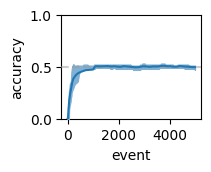

In [13]:
plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve(accuracies2[:50000], y_bottom=0, y_top=1, label="all")
plt.axhline(0.5, color='#999999', alpha=0.5, linestyle='--', zorder=5)
# plot_curve(accuracies1_2[:50000], color="#2CA02C", color2="#8ECFC9", y_bottom=0, y_top=1, label="Top1")
# plt.legend(loc='upper right')
plt.ylabel("accuracy")
plt.xlabel("event")

## SeL-NAL

In [14]:
def create_model(n_columns, n_nodes):
    # Create the model
    g = Group(n_columns, n_nodes)
    g.thresh = 0.8
    g.p_plus = 2 #1.95
    g.p_minus = 0.99 #0.9
    g.p_minus2 = 0.01

    for idx, column in enumerate(g.columns):
        column.mark = idx
    return g

def test_model(g: Group, data, top1=False):
    print(len(data))
    print(data[:20])
    accuracies = []
    n_anticipations = []

    profiler = Profiler(100)
    for i, (idx, idx_next) in enumerate((tqdm(zip(data[:-1], data[1:]), total=len(data)-1))):
        candidates: set[Node] = g.activate(idx)
        anticipations = set()
        if not top1:
            for candidate in candidates:
                anticipations.add(candidate.column.mark)
        else:
            if len(candidates) > 0:
                candidate = max(candidates, key=lambda node: node.activity_pred)
                anticipations.add(candidate.column.mark)

        ''' compute the accuracy '''
        acc = profiler.observe(anticipations, idx_next)
        accuracies.append(acc)
        ''' count the number of valid anticipations '''
        a = np.array(g.columns[idx].get_activities(), dtype=bool)
        if not all(a):
            n_anticipations.append((len(anticipations), sum(a)))
        # n_anticipations.append(len(anticipations))
        
    return accuracies, g, n_anticipations

In [15]:
g1 = create_model(26, 10)
accuracies3, _, _ = test_model(g1, data, top1=True)

5000
[3, 5, 2, 6, 0, 6, 13, 19, 3, 5, 2, 6, 0, 11, 14, 1, 4, 5, 2, 6]


100%|██████████| 4999/4999 [00:00<00:00, 10466.04it/s]


Text(0.5, 0, 'event')

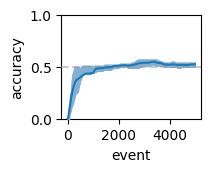

In [16]:
plt.figure(figsize=(2,1.6))
plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve(accuracies3[:50000], y_bottom=0, y_top=1, label="all")
plt.axhline(0.5, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("accuracy")
plt.xlabel("event")

## Compare

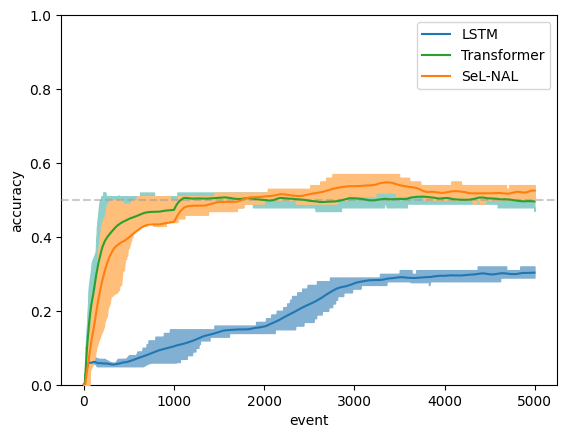

In [17]:
plt.figure()
# plt.subplots_adjust(left=0.3, right=1.0, top=0.95, bottom=0.3)
plot_curve(accuracies1[:50000], color='#1F77B4', color2="#82B0D2", y_bottom=0, y_top=1, label="LSTM")
plot_curve(accuracies2[:50000], color="#2CA02C", color2="#8ECFC9", y_bottom=0, y_top=1, label="Transformer")
plot_curve(accuracies3[:50000], color="#FF7F0E", color2="#FFBE7A", y_bottom=0, y_top=1, label="SeL-NAL")
plt.legend()
plt.axhline(0.5, color='#999999', alpha=0.5, linestyle='--', zorder=5)
plt.ylabel("accuracy")
plt.xlabel("event")
plt.savefig("Figures/compare.pdf")